In [2]:
import warnings
warnings.filterwarnings('ignore')
import random

#utils
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder


import torch
from torchmetrics.functional import r2_score

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.tuner import Tuner

from pytorch_forecasting import Baseline, DeepAR, NBeats, TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import RMSE, MAE, SMAPE, MultiLoss, MASE
from pytorch_lightning.loggers import TensorBoardLogger


In [66]:
def fix_random_seeds(seed=42):
    # Set Python random seed
    random.seed(seed)

    # Set NumPy random seed
    np.random.seed(seed)

    # Set PyTorch random seed for CPU and CUDA devices
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

fix_random_seeds()

In [67]:
df = pd.read_csv('./full_data_sum.csv')

In [68]:
df

,square_id,date,hour,sms_in,sms_out,call_in,call_out,internet
0,48,2013-10-31,23,10.466148,5.085509,4.017373,3.098583,921.901244
1,48,2013-11-01,0,4.657351,3.054674,2.605716,2.348039,804.563753
2,48,2013-11-01,1,4.883931,3.289720,1.509068,0.316719,806.867571
3,48,2013-11-01,2,2.522158,0.806494,0.274891,0.585070,812.316221
4,48,2013-11-01,3,2.053634,0.888435,1.104906,0.497522,639.142303
...,...,...,...,...,...,...,...,...
3137828,9987,2014-01-01,18,20.552035,10.466213,13.017935,24.573671,402.703638
3137829,9987,2014-01-01,19,21.248123,16.718503,12.415021,10.591490,410.096122
3137830,9987,2014-01-01,20,15.456689,8.256480,5.809288,8.035154,411.594966
3137831,9987,2014-01-01,21,10.774990,10.883610,5.936621,7.315528,394.161006


In [69]:
# Предобработаем даты к удобному формату
df['date'] = pd.to_datetime(df['date'])
df['dt'] = pd.to_datetime(df.date) + df.hour.astype('timedelta64[h]')

# Для создания датасета нужно перейти от действительных значений времени к временным шагам
dates_transformer = LabelEncoder()
df['time_idx'] = dates_transformer.fit_transform(df.dt)
df['time_idx'] += 1

# Категориальные переменные должны быть в строковом типе
df['square_id'] = df['square_id'].astype(str)
df

,square_id,date,hour,sms_in,sms_out,call_in,call_out,internet,dt,time_idx
0,48,2013-10-31,23,10.466148,5.085509,4.017373,3.098583,921.901244,2013-10-31 23:00:00,1
1,48,2013-11-01,0,4.657351,3.054674,2.605716,2.348039,804.563753,2013-11-01 00:00:00,2
2,48,2013-11-01,1,4.883931,3.289720,1.509068,0.316719,806.867571,2013-11-01 01:00:00,3
3,48,2013-11-01,2,2.522158,0.806494,0.274891,0.585070,812.316221,2013-11-01 02:00:00,4
4,48,2013-11-01,3,2.053634,0.888435,1.104906,0.497522,639.142303,2013-11-01 03:00:00,5
...,...,...,...,...,...,...,...,...,...,...
3137828,9987,2014-01-01,18,20.552035,10.466213,13.017935,24.573671,402.703638,2014-01-01 18:00:00,1484
3137829,9987,2014-01-01,19,21.248123,16.718503,12.415021,10.591490,410.096122,2014-01-01 19:00:00,1485
3137830,9987,2014-01-01,20,15.456689,8.256480,5.809288,8.035154,411.594966,2014-01-01 20:00:00,1486
3137831,9987,2014-01-01,21,10.774990,10.883610,5.936621,7.315528,394.161006,2014-01-01 21:00:00,1487


In [70]:
dates = sorted(df.date.unique())
train_dates = dates[:49]
val_dates = dates[49:-1]
test_dates = dates[-1:]

train = df[df.date.isin(train_dates)]
val = df[df.date.isin(val_dates)]
test = df[df.date.isin(test_dates)]

train_cutoff = train['time_idx'].max()
validation_cutoff = test['time_idx'].max() - 25
train

,square_id,date,hour,sms_in,sms_out,call_in,call_out,internet,dt,time_idx
0,48,2013-10-31,23,10.466148,5.085509,4.017373,3.098583,921.901244,2013-10-31 23:00:00,1
1,48,2013-11-01,0,4.657351,3.054674,2.605716,2.348039,804.563753,2013-11-01 00:00:00,2
2,48,2013-11-01,1,4.883931,3.289720,1.509068,0.316719,806.867571,2013-11-01 01:00:00,3
3,48,2013-11-01,2,2.522158,0.806494,0.274891,0.585070,812.316221,2013-11-01 02:00:00,4
4,48,2013-11-01,3,2.053634,0.888435,1.104906,0.497522,639.142303,2013-11-01 03:00:00,5
...,...,...,...,...,...,...,...,...,...,...
2479889,9978,2013-12-18,23,5.695077,3.652851,3.226874,4.314335,762.569129,2013-12-18 23:00:00,1153
2479913,9984,2013-12-18,23,10.645971,5.082189,1.799534,4.333646,432.213402,2013-12-18 23:00:00,1153
2479937,9985,2013-12-18,23,11.564205,4.800497,1.900831,3.718794,557.261952,2013-12-18 23:00:00,1153
2479961,9986,2013-12-18,23,7.842615,4.817194,1.324212,0.723416,651.216717,2013-12-18 23:00:00,1153


In [71]:
to_select = ['6974', '6554', '8966', '7445', '9361', '5557', '8847', '6875', '3862', '3527', '6274', '7155', '8087', '6071', '5445', '6745', '9986', '4349', '4972', '3234', '8045', '8380', '9877', '4639', '7987', '4657', '9398', '6077', '4478', '1684', '3958', '3258', '3554', '6754', '8176', '5473', '6846', '8502', '4144', '2247', '4664', '3957', '4973', '6472', '8046', '8242', '2145', '9778', '7552', '9869', '8958', '7055', '6836', '5451', '4040', '3532', '8891', '8757', '7167', '9150', '6467', '9474', '7154', '4345', '8558', '3928', '5443', '9785', '7424', '6664', '6546', '4830', '2654', '5245', '4128', '5368', '5447', '48', '7161', '8152', '4446', '4341', '4667', '5646', '7271', '6766', '6250', '6662', '7173', '7769', '6050', '4061', '8273', '4367', '3755', '3334', '8561', '4578', '3462', '8311', '7085', '3966', '3551', '6473', '8464', '8283', '8247', '7672', '8148', '4464', '7786', '4563', '3945', '6252', '4874', '6466', '5047', '3929', '8673', '6465', '5649', '7562', '3674', '8534', '3558', '7722', '4550', '8056', '3353', '7389', '5344', '4047', '6470', '3967', '6053', '4279', '8332', '6854', '7226', '8854', '6852', '3233', '6054', '7144', '4658', '7980', '6270', '5848', '6585', '7306', '5457', '7468', '6645', '5145', '6055', '5357', '4343', '4029', '3118', '3553', '4058', '6052', '4129', '3836', '5851', '3868', '4362', '6953', '6451', '4443', '3360', '4444', '5544', '4351', '9483', '9684', '6775', '3659', '4669', '7822', '851', '4642', '7341', '8776', '4452', '5847', '4056', '2960', '5957', '3632', '4876', '4350', '6444', '3759', '6447', '7754', '7240', '8286', '6972', '8177', '3863', '8459', '4742', '5636', '3954', '8278', '6297', '6461', '6869', '3871', '7073', '9770', '6695', '7375', '8011', '6647', '7143', '7753', '7540', '6833', '8885', '8934', '4889', '1150', '4158', '4526', '4378', '9598', '8856', '5669', '4354', '3655', '6961', '4748', '1147', '8004', '3763', '8274', '1349', '8562', '6976', '9155', '8751', '5865', '7172', '6648', '4826', '3748', '8791', '4948', '4542', '3285', '4428', '4951', '5437', '7684', '7354', '6355', '5551', '4147', '7163', '7156', '8744', '4057', '7724', '3960', '6459', '4327', '9143', '4777', '5458', '3255', '1555', '4743', '5953', '4066', '7324', '4851', '6154', '4666', '6769', '5450', '7273', '7075', '4678', '8746', '5755', '4453', '8013', '7551', '3432', '5947', '7046', '4871', '3661', '3854', '3767', '8374', '5948', '7556', '4852', '3845', '6663', '4243', '8688', '9351', '6260', '6371', '4027', '4565', '5543', '3962', '3828', '4344', '5372', '7256', '5977', '8049', '6877', '4726', '6572', '8441', '5550', '4379', '6966', '8410', '7305', '4143', '8051', '8833', '5741', '3427', '8085', '7453', '7353', '8435', '6872', '5273', '6756', '4068', '3347', '7852', '5750', '6862', '6046', '5653', '4276', '5753', '7813', '9266', '5146', '8835', '8271', '3671', '6150', '8071', '6671', '3765', '3654', '6152', '7065', '8635', '6153', '3733', '7265', '7064', '5028', '6971', '3970', '4733', '6151', '4228', '6533', '8312', '8756', '3548', '7623', '6372', '4553', '3959', '3673', '4226', '7342', '6755', '6771', '6367', '8047', '6853']

df = df[df.square_id.isin(to_select)]
train = train[train.square_id.isin(to_select)]
val = val[val.square_id.isin(to_select)]
test = test[test.square_id.isin(to_select)]
df

,square_id,date,hour,sms_in,sms_out,call_in,call_out,internet,dt,time_idx
0,48,2013-10-31,23,10.466148,5.085509,4.017373,3.098583,921.901244,2013-10-31 23:00:00,1
1,48,2013-11-01,0,4.657351,3.054674,2.605716,2.348039,804.563753,2013-11-01 00:00:00,2
2,48,2013-11-01,1,4.883931,3.289720,1.509068,0.316719,806.867571,2013-11-01 01:00:00,3
3,48,2013-11-01,2,2.522158,0.806494,0.274891,0.585070,812.316221,2013-11-01 02:00:00,4
4,48,2013-11-01,3,2.053634,0.888435,1.104906,0.497522,639.142303,2013-11-01 03:00:00,5
...,...,...,...,...,...,...,...,...,...,...
3137804,9986,2014-01-01,18,22.120756,11.599022,13.892449,25.985073,442.079424,2014-01-01 18:00:00,1484
3137805,9986,2014-01-01,19,23.144062,18.374765,13.586837,11.494082,445.847545,2014-01-01 19:00:00,1485
3137806,9986,2014-01-01,20,17.494948,9.148906,6.401043,8.166513,462.300016,2014-01-01 20:00:00,1486
3137807,9986,2014-01-01,21,12.454415,12.014384,6.076593,7.502647,428.085868,2014-01-01 21:00:00,1487


In [79]:
max_encoder_length = 60
max_prediction_length = 24


context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    train,
    time_idx="time_idx",
    target="internet",
    categorical_encoders={"square_id": NaNLabelEncoder().fit(train.square_id)},
    group_ids=["square_id"],
    static_categoricals=["square_id"], # Deep AR позволяет учитывать статичные
                                       # категориальные признаки, в нашем случае это id станции
    time_varying_unknown_reals=["internet"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    allow_missing_timesteps=False
)

validation = TimeSeriesDataSet.from_dataset(training,
                                            df,
                                            min_prediction_idx=train_cutoff + 1)

In [83]:
train

,square_id,date,hour,sms_in,sms_out,call_in,call_out,internet,dt,time_idx
0,48,2013-10-31,23,10.466148,5.085509,4.017373,3.098583,921.901244,2013-10-31 23:00:00,1
1,48,2013-11-01,0,4.657351,3.054674,2.605716,2.348039,804.563753,2013-11-01 00:00:00,2
2,48,2013-11-01,1,4.883931,3.289720,1.509068,0.316719,806.867571,2013-11-01 01:00:00,3
3,48,2013-11-01,2,2.522158,0.806494,0.274891,0.585070,812.316221,2013-11-01 02:00:00,4
4,48,2013-11-01,3,2.053634,0.888435,1.104906,0.497522,639.142303,2013-11-01 03:00:00,5
...,...,...,...,...,...,...,...,...,...,...
2479385,9778,2013-12-18,23,6.156315,26.139986,1.183995,3.782617,435.591284,2013-12-18 23:00:00,1153
2479433,9785,2013-12-18,23,7.671334,8.360217,3.849561,2.622869,331.809561,2013-12-18 23:00:00,1153
2479601,9869,2013-12-18,23,11.153491,10.116787,2.752423,3.308822,486.650959,2013-12-18 23:00:00,1153
2479649,9877,2013-12-18,23,5.962898,7.198708,2.717230,3.948449,701.942230,2013-12-18 23:00:00,1153


In [76]:
batch_size = 128
train_dataloader = training.to_dataloader(
    train=True,
    batch_size=batch_size,
    num_workers=4,
    drop_last=True,
    batch_sampler="synchronized"
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=4, batch_sampler="synchronized"
)

In [74]:
random_bs = np.random.choice(df.square_id.unique(), 150)

train_sample = TimeSeriesDataSet.from_dataset(training, train[train.square_id.isin(random_bs)])
validation_sample = TimeSeriesDataSet.from_dataset(training, val[val.square_id.isin(random_bs)], min_prediction_idx=train_cutoff + 1)


train_subset_loader = train_sample.to_dataloader(
    train=True,
    batch_size=batch_size,
    num_workers=4,
    drop_last=True,
    batch_sampler="synchronized")

val_subset_loader = validation_sample.to_dataloader(
    train=False, batch_size=batch_size, num_workers=4, batch_sampler="synchronized"
)

In [75]:
pl.seed_everything(42)

trainer = pl.Trainer(accelerator='cpu', gradient_clip_val=1e-1)
net = DeepAR.from_dataset(
    training,
    learning_rate=3e-2,
    hidden_size=60,
    rnn_layers=5,
    optimizer="Adam",
)

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [32]:
logger = TensorBoardLogger('DeepAR_Fit', name='result_deepAR_model')

early_stop_callback = EarlyStopping(monitor="val_loss",
                                    min_delta=1e-4,
                                    patience=10,
                                    verbose=False,
                                    mode="min")
trainer = pl.Trainer(
    max_epochs=3,
    accelerator='cpu',
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    # limit_train_batches=200,
    limit_val_batches=200,
    enable_checkpointing=True,
    logger=logger
)

trainer.fit(
    net,
    train_dataloaders=train_subset_loader,
    val_dataloaders=val_subset_loader
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 1     
3 | rnn                    | LSTM                   | 132 K 
4 | distribution_projector | Linear                 | 122   
------------------------------------------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0.530     Total estimated model params size (MB)


Epoch 2: 100%|██████████| 1070/1070 [02:07<00:00,  8.42it/s, v_num=1, train_loss_step=7.040, val_loss=6.460, train_loss_epoch=6.750]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 1070/1070 [02:13<00:00,  8.01it/s, v_num=1, train_loss_step=7.040, val_loss=6.460, train_loss_epoch=6.750]


In [33]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

In [34]:
def evaluate(predictions, answers):
    rmse = RMSE()(predictions, answers).item()
    smape = SMAPE()(predictions, answers).item()
    mae = MAE()(predictions, answers).item()
    r2 = r2_score(predictions, answers).item()

    print(f"Evaluation Metrics:")
    print(f"RMSE: {rmse:.3f}")
    print(f"SMAPE: {smape:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"R-squared: {r2:.3f}")

In [35]:
val_answers = torch.cat([y[0] for x, y in iter(val_subset_loader)]).to('cpu')

predictions = best_model.predict(val_subset_loader,
                                 trainer_kwargs=dict(accelerator='cpu'), )

In [36]:
evaluate(predictions, val_answers)

Evaluation Metrics:
RMSE: 154.360
SMAPE: 0.234
MAE: 129.252
R-squared: -0.003


In [37]:
test_dataset = TimeSeriesDataSet.from_dataset(training,
                                      df,
                                      min_prediction_idx=validation_cutoff + 1,
                                      predict_mode=True)

test_loader = test_dataset.to_dataloader(
    train=False, batch_size=batch_size, num_workers=4, batch_sampler="synchronized"
)

In [47]:
test_answers = torch.cat([y[0] for x, y in iter(test_loader)]).to('cpu')
test_answers

tensor([[715.5753, 500.3387, 424.6568, 376.4969, 355.0212, 369.6034, 332.2556,
         307.5600, 345.3864, 412.2969, 501.5686, 523.4165, 741.7690, 595.1033,
         545.9710, 598.1264, 719.5903, 730.1771, 765.0656, 686.1367, 726.3795,
         614.4366, 634.4540, 559.8148]])

In [48]:
raw_predictions = net.predict(test_loader, mode="prediction", return_x=True)
test_preds = raw_predictions[0].to('cpu')
x = raw_predictions[1]['encoder_target'].to('cpu')
test_preds

tensor([[578.4401, 546.2576, 543.7201, 547.9385, 559.3878, 539.3456, 550.3571,
         518.3303, 557.2996, 555.9861, 545.7904, 554.5197, 539.5081, 554.6985,
         539.6301, 543.2159, 532.5077, 543.8599, 540.1074, 541.4188, 539.5891,
         554.1083, 541.2001, 547.8273]])

In [46]:
evaluate(test_preds, test_answers)

ValueError: Needs at least two samples to calculate r2 score.

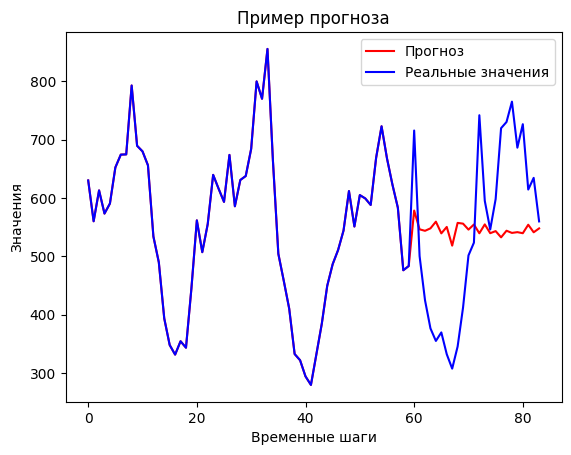

In [65]:
# Номер базовой станции для визуализации
base_station_num = 60

# Можно визуализировать отдельные прогнозы
base_station_num = 0
plt.plot(np.concatenate([x[base_station_num], test_preds[base_station_num]]), color='red', label='Прогноз')
plt.plot(np.concatenate([x[base_station_num], test_answers[base_station_num]]), color='blue', label='Реальные значения')


# Добавляем подписи к осям и легенду
plt.xlabel('Временные шаги')
plt.ylabel('Значения')
plt.legend()
plt.title(f'Пример прогноза')

# Отображаем график
plt.show()

In [51]:
np.concatenate([x[base_station_num], test_preds[base_station_num]])

IndexError: index 60 is out of bounds for dimension 0 with size 1

In [64]:
x[0]

tensor([630.0047, 560.0737, 613.0171, 573.2466, 590.4644, 652.2911, 674.2770,
        674.6778, 792.7292, 689.4401, 679.8102, 655.9183, 534.0636, 489.7262,
        393.5372, 348.0159, 331.5974, 354.4940, 343.3980, 445.1499, 561.6210,
        507.0727, 555.1950, 639.5898, 615.9816, 593.2657, 673.7753, 585.7581,
        630.7897, 637.6028, 684.1740, 799.7857, 769.9409, 855.3912, 664.4848,
        504.3100, 458.0179, 410.2892, 332.5864, 321.9645, 294.2700, 279.6387,
        332.0216, 384.5712, 449.5302, 486.5457, 510.8065, 544.1977, 611.8156,
        551.0796, 604.9289, 599.1833, 588.0329, 668.8915, 722.8218, 667.7217,
        622.9550, 583.2996, 476.1282, 483.3637])